# **E10: Detecci√≥n de Anomal√≠as con LSTM**  

## **Objetivo**  
Implementar un modelo **LSTM** para detectar anomal√≠as en series temporales de consumo energ√©tico, asegurando que se ejecute eficientemente sin GPU.

## **Datos de entrada**  
Un dataset con las siguientes columnas:  
- **Consumo Energ√≠a (kWh)**  
- **Generaci√≥n FV (kWh)**  
- **Temperatura (¬∞C)**  
- **Radiaci√≥n Solar (W/m¬≤)**  

---

# **Pasos a seguir**  

## 1. Cargar y visualizar los datos  

In [42]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt

import tensorflow as tf  
from tensorflow.keras.models import Sequential, load_model  
from tensorflow.keras.layers import LSTM, Dense, Dropout  
from sklearn.preprocessing import MinMaxScaler  # Configurar para que use solo CPU  

import os  
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  

# Cargar dataset
df = pd.read_csv("data/m4_datos_energia_canarias.csv", usecols=range(1, 6) )

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.set_index('Fecha')
# Ver las primeras filas
print(df.head())

            Consumo Energ√≠a (kWh)  Generaci√≥n FV (kWh)  Temperatura (¬∞C)  \
Fecha                                                                      
2023-01-01             259.514697           164.004193         20.477757   
2023-01-02             299.305789           173.408325         18.215363   
2023-01-03             307.509279           170.269137         21.074604   
2023-01-04             316.606347           171.587572         16.938845   
2023-01-05             299.377762           158.578316         22.488135   

            Radiaci√≥n Solar (W/m¬≤)  
Fecha                               
2023-01-01              496.039170  
2023-01-02              504.088217  
2023-01-03              400.357468  
2023-01-04              546.224484  
2023-01-05              517.902633  


In [43]:
df.describe()

Consumo Energ√≠a (kWh)  Generaci√≥n FV (kWh)  Temperatura (¬∞C)  \
count             362.000000           360.000000        361.000000   
mean              286.920289           199.401433         20.226564   
std                25.891524            25.749239          4.038290   
min               227.544904           139.773673         10.635462   
25%               268.790405           179.458116         16.950147   
50%               290.496053           199.686554         20.112155   
75%               306.836800           219.873898         23.564546   
max               343.118236           260.035128         29.389797   

       Radiaci√≥n Solar (W/m¬≤)  
count              363.000000  
mean               604.009230  
std                 83.308007  
min                356.193982  
25%                538.175121  
50%                605.683791  
75%                663.399229  
max                820.997031

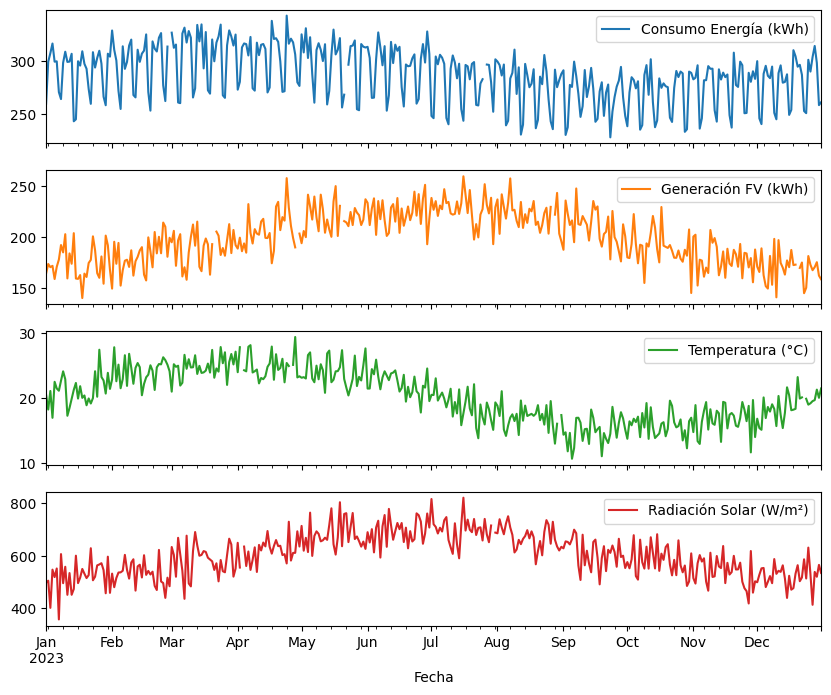

In [44]:
# Visualizar las variables clave
df.plot(subplots=True, figsize=(10, 8))
plt.show()

---

## 2. Preprocesamiento  
- **Rellenar valores nulos**  
- **Normalizar datos** para mejorar la detecci√≥n  

In [45]:
# Interpolar valores nulos  
df.interpolate(inplace=True)  

# Normalizar datos  
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Convertir datos en formato de ventana temporal  
def create_sequences(data, seq_length=10):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 10  # Ventana de 10 pasos  
X, y = create_sequences(df_scaled, seq_length)


---

## 3. Entrenar Modelo LSTM

In [46]:
# Definir modelo LSTM  
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, df.shape[1])),
    Dropout(0.2),
    LSTM(30, activation='relu', return_sequences=False),
    Dense(df.shape[1])
])

model.compile(optimizer="adam", loss="mse")

# Entrenar el modelo  
model.fit(X, y, epochs=80, batch_size=24, shuffle=False, verbose=1)


Epoch 1/80


/Users/jballesteros/.virtualenvs/ibbi/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 15ms/step - loss: 0.2988
Epoch 2/80
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 15ms/step - loss: 0.0673
Epoch 3/80
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 31ms/step - loss: 0.0536
Epoch 4/80
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step - loss: 0.0345
Epoch 5/80
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 14ms/step - loss: 0.0349
Epoch 6/80
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 19ms/step - loss: 0.0338
Epoch 7/80
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 19ms/step - loss: 0.0312
Epoch 8/80
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 18ms/step - loss: 0.0292
Epoch 9/80
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step - loss: 0.0270
Epoch 10/80
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

üìå Explicaci√≥n:

**Capa LSTM**
 - LSTM con 50 neuronas: Captura patrones temporales en los datos.
 - activation='relu': Usa la funci√≥n de activaci√≥n ReLU para mejorar el aprendizaje.
 - return_sequences=True: Devuelve la secuencia completa, necesaria cuando hay m√°s capas LSTM.
 - input_shape=(seq_length, df.shape[1]):
   - seq_length=10 ‚Üí Cada entrada usa los √∫ltimos 10 registros como ventana temporal.
   - df.shape[1] ‚Üí El n√∫mero de variables en el dataset (Consumo, Generaci√≥n FV, Temperatura, etc.).

**Capa Dropout**
- Se usa para evitar sobreajuste, eliminando aleatoriamente el 20% de las conexiones en cada iteraci√≥n.

**Segunda Capa LSTM**
 - 30 neuronas para extraer informaci√≥n de la secuencia procesada por la primera capa.
 - return_sequences=False porque es la √∫ltima capa LSTM y queremos solo el resultado final.

**Capa Dropout**
- Se usa para evitar sobreajuste, eliminando aleatoriamente el 20% de las conexiones en cada iteraci√≥n.

**Capa Densa de Salida**
- Red completamente conectada que devuelve un vector del mismo tama√±o que la entrada.
- Permite reconstruir los valores originales y calcular el error para detectar anomal√≠as.

### 3.1. Almacenar modelo

In [47]:
# Guardar modelo en disco
model.save("models/lstm_model.h5")
print("Modelo guardado en disco como 'lstm_model.h5'")


Modelo guardado en disco como 'lstm_model.h5'


### 3.2 Cargar modelo

In [48]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

# Definir la funci√≥n de p√©rdida expl√≠citamente
mse = MeanSquaredError()

# Cargar modelo asegurando que reconoce la funci√≥n de p√©rdida
autoencoder_loaded = load_model("models/lstm_model.h5", compile=False)

# Compilar el modelo cargado
autoencoder_loaded.compile(optimizer="adam", loss=mse)

print("Modelo cargado y recompilado exitosamente.")


Modelo cargado y recompilado exitosamente.


---

## 4. Detecci√≥n de anomal√≠as

In [49]:
# Obtener predicciones del modelo  
predictions = model.predict(X)

# Calcular error de reconstrucci√≥n  
mse = np.mean(np.power(y - predictions, 2), axis=1)

# Definir umbral para anomal√≠as (percentil 95)  
threshold = np.percentile(mse, 95)

# Etiquetar anomal√≠as  
df["Anomaly"] = np.append(np.zeros(seq_length), mse > threshold)

# Mostrar conteo de anomal√≠as detectadas  
print(df["Anomaly"].value_counts())


12/12 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 32ms/step
Anomaly
0.0    347
1.0     18
Name: count, dtype: int64


In [50]:
# Contar el n√∫mero total de anomal√≠as detectadas
num_anomalies = (df["Anomaly"] == True).sum()
print(f"N√∫mero total de anomal√≠as detectadas: {num_anomalies}")


N√∫mero total de anomal√≠as detectadas: 18


---

## 4. Visualizar anomal√≠as  

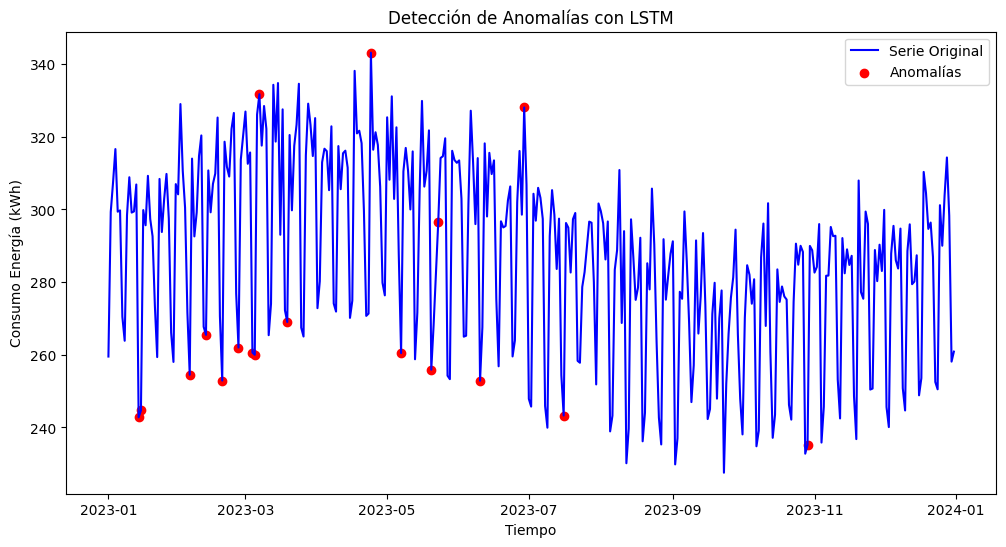

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Consumo Energ√≠a (kWh)"], label="Serie Original", color="blue")
plt.scatter(df.index[df["Anomaly"] == 1], df["Consumo Energ√≠a (kWh)"][df["Anomaly"] == 1],  
            color='red', label='Anomal√≠as', marker='o')
plt.xlabel("Tiempo")
plt.ylabel("Consumo Energ√≠a (kWh)")
plt.title("Detecci√≥n de Anomal√≠as con LSTM")
plt.legend()
plt.show()


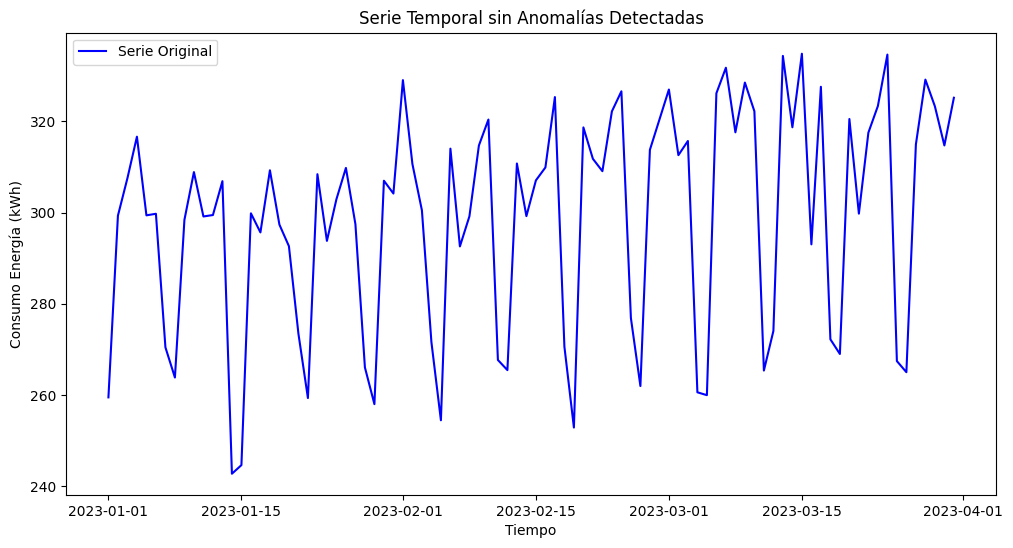

In [52]:
# Aumentamos el zoom en el primer trimestre
plot_df = df[df.index.month < 4]
# 5Ô∏è‚É£ Gr√°fico de l√≠nea con anomal√≠as
plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df["Consumo Energ√≠a (kWh)"], label="Serie Original", color="blue")
plt.xlabel("Tiempo")
plt.ylabel("Consumo Energ√≠a (kWh)")
plt.title("Serie Temporal sin Anomal√≠as Detectadas")
plt.legend()
plt.show()

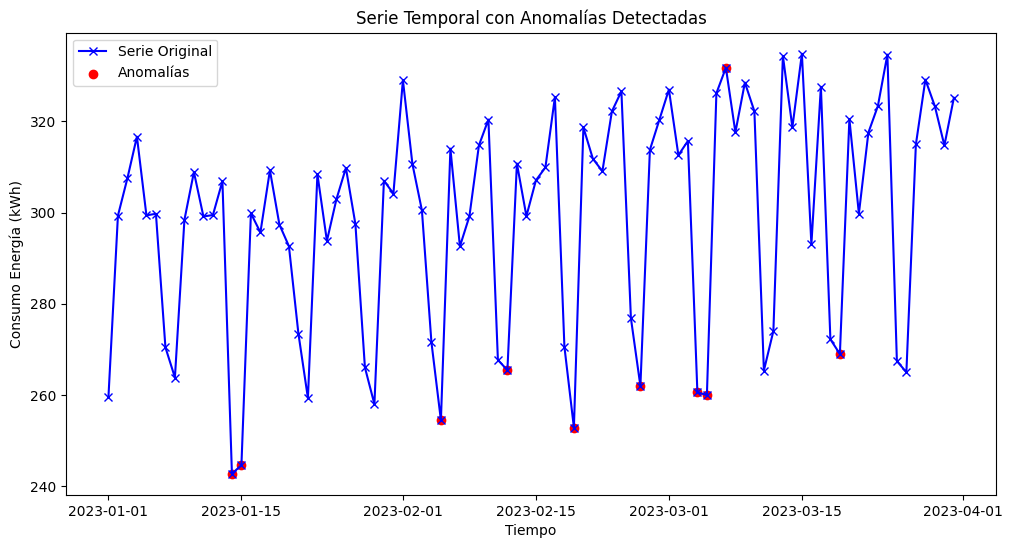

In [53]:
# 5Ô∏è‚É£ Gr√°fico de l√≠nea con anomal√≠as
plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df["Consumo Energ√≠a (kWh)"], label="Serie Original", color="blue", marker="x")
plt.scatter(plot_df.index[plot_df["Anomaly"] == True], plot_df["Consumo Energ√≠a (kWh)"][plot_df["Anomaly"] == True],  
            color='red', label='Anomal√≠as', marker='o')
plt.xlabel("Tiempo")
plt.ylabel("Consumo Energ√≠a (kWh)")
plt.title("Serie Temporal con Anomal√≠as Detectadas")
plt.legend()
plt.show()

---

# **Conclusi√≥n**  
- Autoencoder permite detectar anomal√≠as analizando diferencias en la reconstrucci√≥n de datos normales.
- Sin necesidad de GPU, este enfoque sigue siendo eficiente con tama√±os de batch peque√±os y menos neuronas.
- Extensi√≥n: Probar diferentes valores de encoding_dim o umbrales de detecci√≥n.